# 전력수요예측 모델링

## 목차



### 1. 데이터 load

In [1]:
## module import
import pandas as pd
import numpy as np
from datetime import datetime
from pandas import DataFrame #데이터 전처리 

from statsmodels.tsa.seasonal import seasonal_decompose # decompose
from statsmodels.tsa.stattools import adfuller # stationary test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #AutoCorrelation , Partial AutoCorrelation
import itertools # 보간
from statsmodels.tsa.arima_model import ARIMA # SARIMA랑 다른 패키지
import statsmodels.api as sm # statsmodels


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from matplotlib import font_manager, rc
import matplotlib

#한글 폰트 등록
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [3]:
# import pandas as pd

# # 판다스 데이터프레임(DataFrame)을 출력할 때, 최대 출력할 수 있는 컬럼을 100개로 늘려줍니다.
# # 이렇게 해야 데이터를 분석할 때 출력해서 확인하기 편합니다.
pd.options.display.max_columns = 300
pd.options.display.max_rows = 300

In [4]:
train = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/train.csv')
test = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/test.csv')
submission = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/submission.csv')

In [5]:
print(train.shape)
print(test.shape)

(16909, 1301)
(8760, 201)


### 2. 결측치 파악

* train 데이터셋의 경우 2016년 7월 26일 11시 ~ 2018년 6월 30일 24시까지 시간 당 전력사용량을 나타내나 80%이상의 결측치를 갖는 값이 대부분임. test셋과 train셋의 세대가 다르기 때문에 우선 test셋의 데이터로 모델링을 진행해봄

In [6]:
# to_datetime

train['Time'] = train['Time'].apply(pd.to_datetime)
train.set_index('Time',inplace=True)

test['Time'] = test['Time'].apply(pd.to_datetime)
test.set_index('Time',inplace=True)

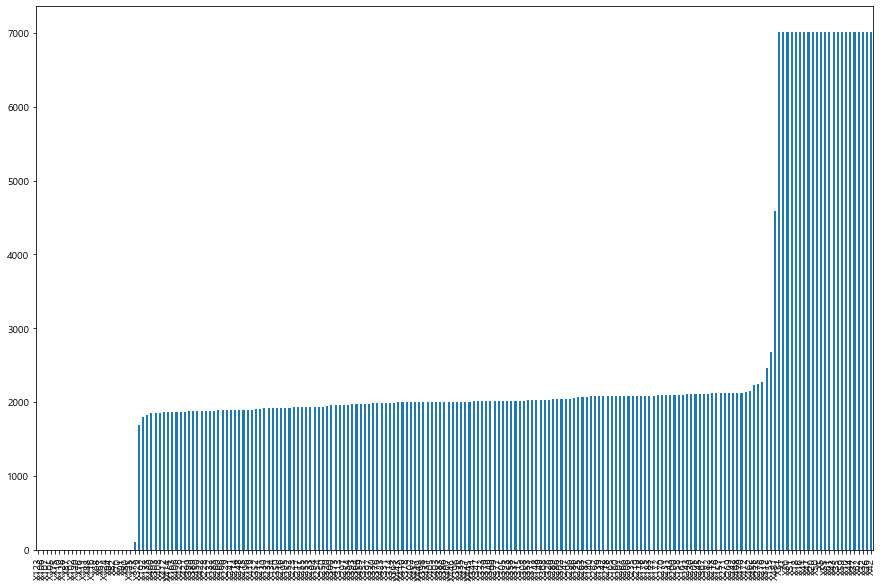

In [7]:
# 결측치 갯수 시각화
test.isnull().sum().sort_values(ascending=True).plot(kind='bar',figsize=(15,10))

* 결측치가 없는 세대를 sample로 정하여 데이터 탐색 진행

In [8]:
## 결측치가 없는 세대
test.loc[:,test.isnull().sum()==0].columns

Index(['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107'],
      dtype='object')

In [9]:
# sample 데이터
test_sample = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']]

* test_sample 데이터를 시간,일,월별로 resampleling

In [10]:
# 일
test_sample_day = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].resample(rule='D').sum()

# 월
test_sample_month = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].resample(rule='M').sum()

# 시간별
test_sample_hours = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']]

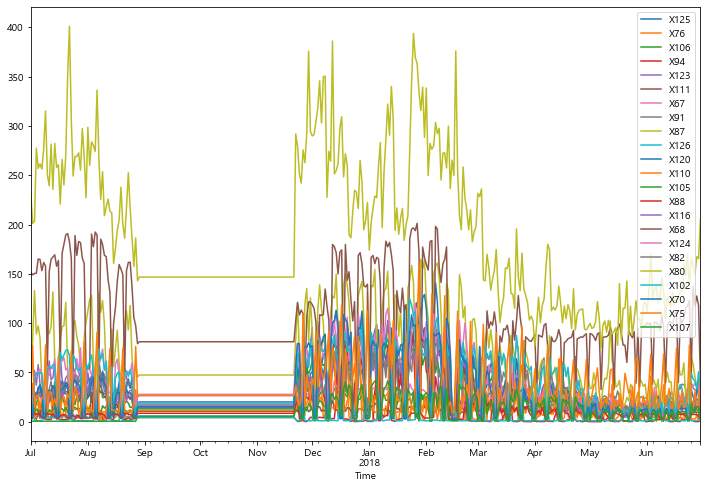

In [11]:
# 일별 전력수요량 합계

test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].resample(rule='D').sum().plot(figsize=(12,8))

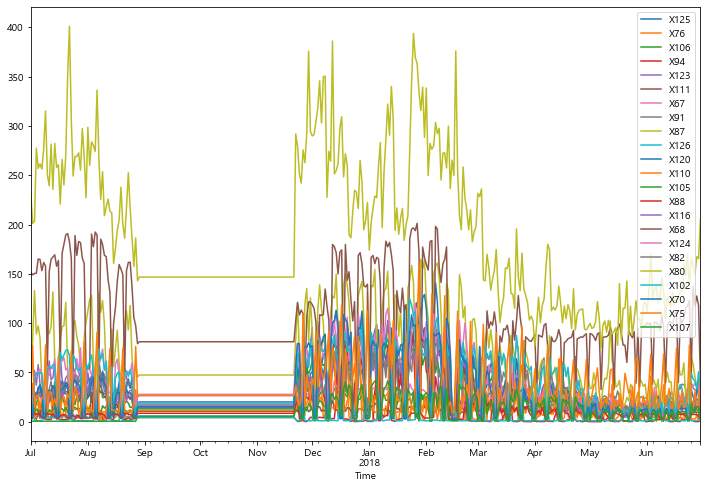

In [12]:
# 월별 전력수요량 합계

test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].resample(rule='D').sum().plot(figsize=(12,8))

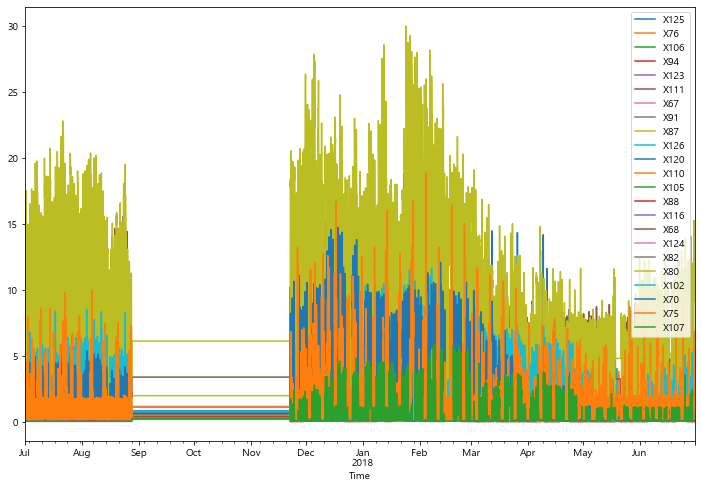

In [13]:
# 시간별 전력수요량 합계

test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].plot(figsize=(12,8))

> 결측치가 없는 test_sample에서 2017년9월~11월 22일까지의 데이터가 같은값을 갖는 특징 확인.
    * 해당 특징이 오류인지, 특정 이유가 있는것인지 파악할 필요

> 시계열 예측을 위한 모델로 HOLT'S-WINTER, ARIMA모델을 적용해 볼것임.

> 모델 적용 전, 데이터 특성 파악 필요
    * 2017년9월~11월까지의 데이터 특징 파악
    * 주택데이터와 상가데이터의 구분
    * 계절,주말에 따른 트렌드 및 계절성 파악
    * 기온,날씨,공휴일 등 예측변수 탐색

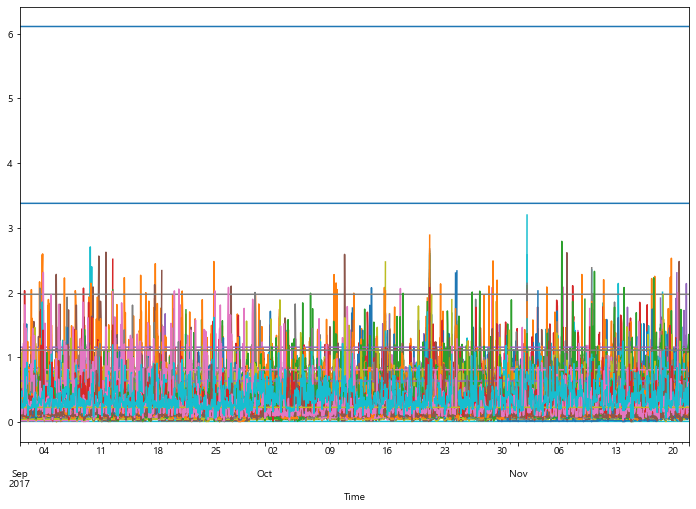

In [14]:
# test데이터 모든 데이터가 9월~11월말까지 같은 값을 갖는지 확인

test['2017-09':'2017-11-21'].plot(figsize=(12,8),legend=False)

> test셋의 모든 데이터가 17년 9월~11월말까지 같은 값을 가지는 것은 아니다.
    * 일부 데이터의 특징? vs 측정오류
    * 모델 적용시 설명력을 감소시킬 가능성 고려

* 전력수요량의 평균적인 크기로 상가와 주택을 구분해 보기

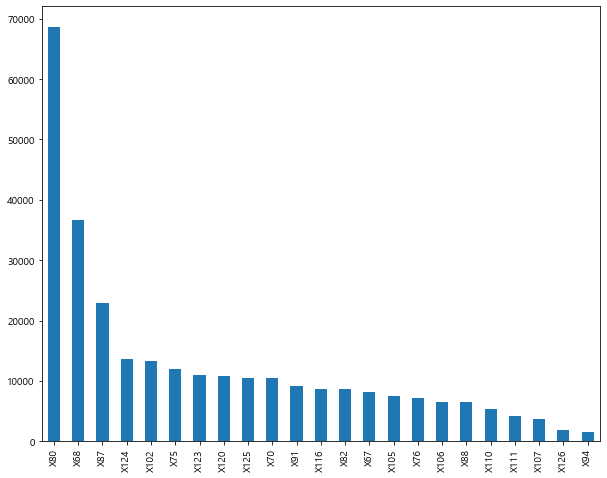

In [15]:
# 시각화 통한 판단
# 결측치 처리후 test 데이터 전체 시각화해보기
test_sample.iloc[:,].sum().sort_values(ascending=False).plot(kind='bar',figsize=(10,8))

### 3. ARIMA 

In [16]:
# X116 세대의 일별 예측을 sample로 Testing

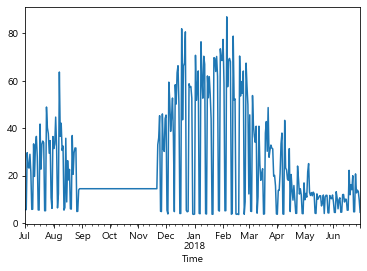

In [17]:
test_sample['X116'].resample(rule='D').sum().plot()

In [18]:
## 3.1 decompose

# decomposition 으로 확인하기

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(test_sample['X116'].resample(rule='D').sum())

C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<Figure size 432x288 with 0 Axes>

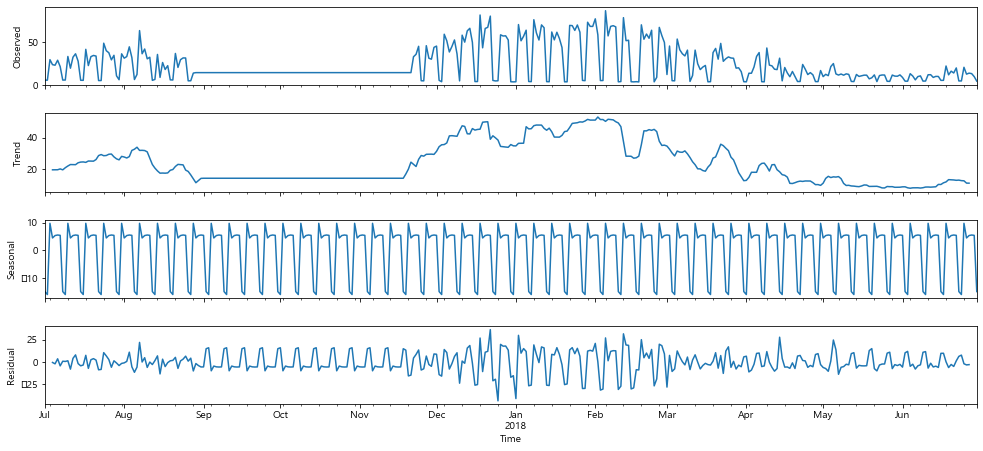

In [19]:
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,7)

In [20]:
# 3.2 stationary Test

# stationary check
def adf_check(ts):
    result = adfuller(ts)
    if result[1] <= 0.05:
        print('Stationary {}'.format(result[1]))
    else :
        print('Non-Stationary {}'.format(result[1]))

In [21]:
adf_check(test_sample['X116'].resample(rule='D').sum())

Non-Stationary 0.641699642360996


In [22]:
# 1st differencing
first_diff = (test_sample['X116'].resample(rule='D').sum() - test_sample['X116'].resample(rule='D').sum().shift(1)).dropna()
adf_check((test_sample['X116'].resample(rule='D').sum() - test_sample['X116'].resample(rule='D').sum().shift(1)).dropna())

Stationary 5.017885244993516e-10


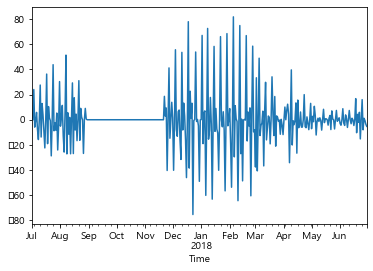

In [23]:
# 1st differencing plot
(test_sample['X116'].resample(rule='D').sum() - test_sample['X116'].resample(rule='D').sum().shift(1)).plot()

In [24]:
# seasonal differencing
seasonal_diff = (test_sample['X116'].resample(rule='D').sum() - test_sample['X116'].resample(rule='D').sum().shift(12)).dropna()
adf_check((test_sample['X116'].resample(rule='D').sum() - test_sample['X116'].resample(rule='D').sum().shift(12)).dropna())

Stationary 0.0003131105291293751


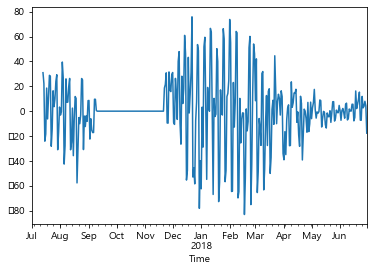

In [25]:
(test_sample['X116'].resample(rule='D').sum() - test_sample['X116'].resample(rule='D').sum().shift(12)).plot()

In [26]:
# 1st & seasonal differencing

res_diff = first_diff - seasonal_diff
adf_check(res_diff.dropna())

Stationary 0.022025364543090557


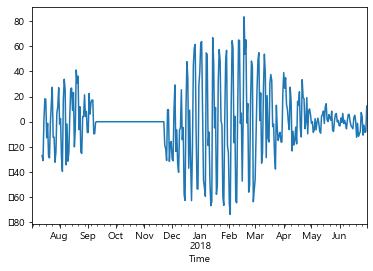

In [27]:
res_diff.plot()

In [28]:
# ARIMA

# parameter searching
import itertools
p = list(range(0,5))
d = [1]
q = [0,1]

pdq = list(itertools.product(p,d,q))

In [29]:
for param in pdq:
    model = ARIMA(test_sample['X116'], order=param)
    result = model.fit(disp=0)
    print('ARIMA{} => AIC : {}'.format(param,result.aic))

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(se

ARIMA(0, 1, 0) => AIC : 25314.68595486614
ARIMA(0, 1, 1) => AIC : 25306.070592302593


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0) => AIC : 25308.295358380547


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1) => AIC : 24532.596634943246
ARIMA(2, 1, 0) => AIC : 25210.989198067633


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1) => AIC : 24383.299870864998


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


ARIMA(3, 1, 0) => AIC : 25209.608333774475


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


ARIMA(3, 1, 1) => AIC : 24385.208331206137


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


ARIMA(4, 1, 0) => AIC : 25198.580024514355


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


ARIMA(4, 1, 1) => AIC : 24329.44602718213


In [30]:
arima_sample = test_sample['X116'].resample(rule='D').sum()

# train ,test split
X = arima_sample.values
size = int(len(X)*0.66)
train_testing,test_testing = X[:size],X[size:]

In [31]:
history = [x for x in train_testing] # train은 그대로 두고 (복사본 생성)

In [32]:
predictions = []

for t in range(len(test_testing)): # test사이즈만큼 prediction
    model = ARIMA(history, order=(4,1,1))
    result = model.fit(disp=0) # disp=0 => warnning메세지 안뜨게
    output = result.forecast() # forcast default인자는 1임 # 즉, 다음거 하나만 예측 # 배열로 저장됨
    yhat = output[0] # yhat => 예측값
    predictions.append(yhat)
    
    # 계속해서 다음꺼 예측하기 위해
    obs = test_testing[t] 
    history.append(obs) # 하나씪 범위 늘림

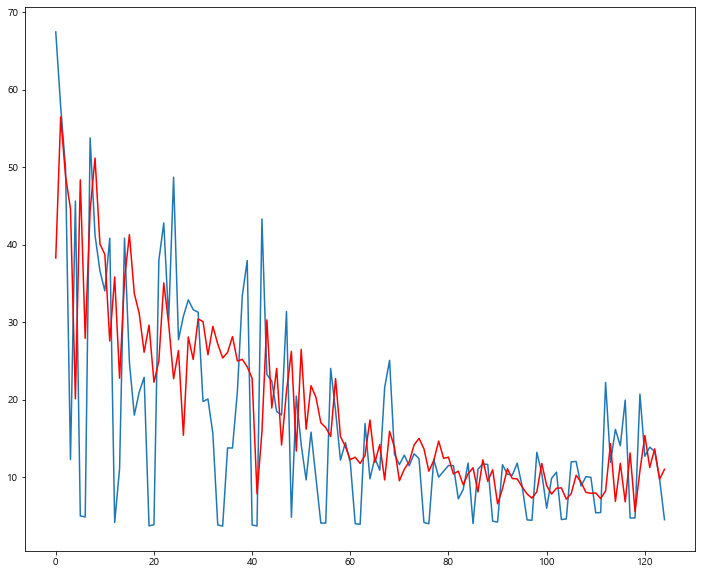

In [33]:
plt.figure(figsize=(12,10))
plt.plot(test_testing)
plt.plot(predictions,color='red')

In [34]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test_testing,predictions)

In [35]:
rmse = np.sqrt(error)
rmse

11.161459221054315

In [36]:
arima_sample.describe()

count    365.00000
mean      23.78091
std       20.16818
min        3.55600
25%       10.49000
50%       14.44800
75%       33.87400
max       87.00300
Name: X116, dtype: float64

> 모델의 성능이 좋지 못하다. train 기간이 짧아서? 9~11월의 측정 이상 때문? 단순 시계열 모델의 한계?

> 머신러닝을 통한 예측을 해보자 

In [37]:
# 우선, 9~11월의 이상 관측치를 해결할것.

# 1. 9~11월의 정상 관측치와 기상데이터의 상관관계 분석 후, 회긔를 통한 예측

In [38]:
# 기상 데이터 load

weather_1 = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/기상_1.csv',encoding='euc-kr',index_col='일시',parse_dates=True)
del weather_1['지점']

weather_2= pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/기상_2.csv',encoding='euc-kr',index_col='일시',parse_dates=True)
del weather_2['지점']

weather = pd.concat([weather_1,weather_2])

In [39]:
weather.head()

,기온(°C),강수량(mm),풍속(m/s),습도(%),일조(hr)
일시,,,,,
2016-07-20 00:00:00,25.7,NaN,1.3,98.0,NaN
2016-07-20 01:00:00,25.6,NaN,1.4,98.0,NaN
2016-07-20 02:00:00,25.4,NaN,0.3,98.0,NaN
2016-07-20 03:00:00,24.9,NaN,1.1,98.0,NaN
2016-07-20 04:00:00,24.7,NaN,0.7,98.0,NaN


C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


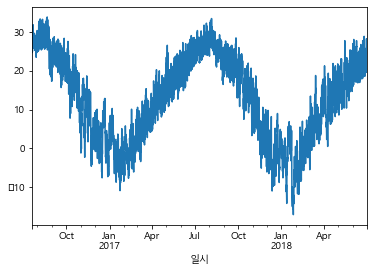

In [40]:
# 인천지역 2016-07-20 ~ 2018-06-30간의 기온,강수량,풍속,습도,일조

weather['기온(°C)'].plot()

In [41]:
# 기온에 따른 전력수요량 파악하기

In [42]:
test_sample['기온'] = weather['기온(°C)']['2017-07':'2018-06']

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [43]:
# 기온이 0도 이하로 떨어질 경우 전력 수요량

test_sample['기온'].resample('M').mean() # 월별 평균기온

Time
2017-07-31    25.829973
2017-08-31    25.463306
2017-09-30    21.867639
2017-10-31    15.751882
2017-11-30     5.976944
2017-12-31    -1.303495
2018-01-31    -3.809140
2018-02-28    -1.818452
2018-03-31     6.867339
2018-04-30    11.902222
2018-05-31    17.000941
2018-06-30    21.235139
Freq: M, Name: 기온, dtype: float64

In [44]:
# 6,7,8,9 / 11,3 / 12,1,2  / 4,5 / 10  

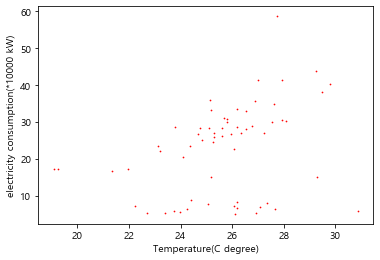

In [45]:
# 6,7,8월
# 여러 세대로 TEST 해볼것

plt.xlabel('Temperature(C degree)')
plt.ylabel('electricity consumption(*10000 kW)')

plt.scatter(test_sample['기온']['2017-06':'2017-08'].resample(rule='D').mean(), test_sample['X125']['2017-06':'2017-08'].resample(rule='D').sum(),s=0.5,
            color="red", label='electricity consumption(measured)')
plt.show()

> 기온이 높아질수록 전기수요량 또한 높아짐

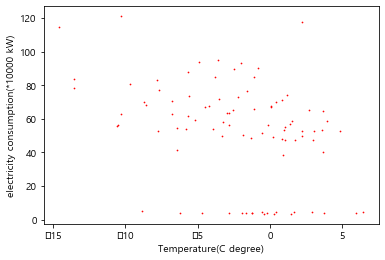

In [46]:
# 6,7,8월
# 여러 세대로 TEST 해볼것

plt.xlabel('Temperature(C degree)')
plt.ylabel('electricity consumption(*10000 kW)')

plt.scatter(test_sample['기온']['2017-12':'2018-02'].resample(rule='D').mean(), test_sample['X125']['2017-12':'2018-02'].resample(rule='D').sum(),s=0.5,
            color="red", label='electricity consumption(measured)')
plt.show()

> 온도가 0~영하권일 경우 평균적인 전력사용량이 높음

In [47]:
test_sample.columns

Index(['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107', '기온'],
      dtype='object')

In [48]:
# test 셋중 결측치 있는 세대
test_sample_nan = test.loc[:,test.isnull().sum() > 0]

In [49]:
test_sample_nan['2017-09':'2017-11-21'].isnull().sum().sort_values(ascending=True)

X73        0
X412      20
X376      20
X423      20
X422      20
X455      20
X393      20
X314      20
X414      20
X363      20
X331      20
X459      20
X378      20
X330      20
X389      20
X450      21
X357      21
X329      21
X399      25
X426      31
X406      33
X367      33
X302      33
X460      33
X408      33
X320      33
X421      33
X473      33
X364      33
X350      33
X354      33
X352      33
X419      36
X300      38
X303      38
X443      39
X410      39
X313      39
X341      42
X312      42
X397      42
X431      42
X299      42
X398      42
X333      42
X347      42
X402      42
X326      43
X349      43
X379      43
X305      43
X337      43
X407      43
X435      43
X368      43
X403      43
X445      43
X457      43
X449      43
X371      43
X396      43
X315      43
X405      43
X383      43
X377      43
X323      43
X386      43
X446      43
X358      43
X308      43
X427      43
X353      44
X462      48
X470      50
X472      50
X468      51
X230      53

In [50]:
test_sample_nan = test_sample_nan['2017-09':'2017-11-21'].loc[:,test_sample_nan['2017-09':'2017-11-21'].isnull().sum() < 656]

In [51]:
test_sample_nan = test_sample_nan.reset_index()

In [52]:
test_sample_nan

,Time,X303,X241,X435,X402,X352,X305,X350,X326,X299,X160,X211,X349,X407,X330,X132,X231,X225,X286,X354,X353,X255,X393,X157,X323,X130,X269,X172,X289,X216,X398,X233,X214,X270,X371,X200,X163,X364,X378,X271,X462,X427,X73,X263,X450,X206,X133,X195,X134,X297,X175,X254,X196,X412,X337,X406,X414,X260,X252,X455,X320,X276,X423,X218,X399,X213,X379,X468,X253,X247,X262,X248,X357,X215,X177,X228,X187,X245,X242,X376,X166,X472,X275,X313,X201,X408,X419,X460,X367,X143,X312,X410,X389,X300,X470,X445,X158,X421,X178,X308,X217,X229,X358,X148,X397,X363,X165,X296,X219,X431,X302,X314,X405,X315,X176,X396,X449,X383,X473,X205,X161,X403,X341,X149,X377,X232,X333,X140,X422,X386,X250,X142,X235,X446,X331,X186,X243,X194,X183,X139,X459,X457,X368,X282,X426,X192,X283,X329,X223,X266,X443,X347,X230
0,2017-09-01 00:00:00,0.263,0.118,0.117,0.083,0.100,0.128,0.152,0.030,0.027,0.105,0.080,0.043,0.155,0.184,0.228,0.064,0.098,0.245,0.030,0.069,0.199,0.052,0.220,0.087,0.255,0.061,0.075,0.117,0.147,0.147,0.140,0.237,0.223,0.076,0.133,0.123,0.065,0.066,0.170,0.024,0.136,0.008,0.193,0.053,0.234,0.047,0.238,0.162,0.029,0.071,0.154,0.279,0.017,0.208,0.482,0.065,0.115,0.308,0.090,0.160,0.072,0.071,0.116,0.015,0.102,0.250,0.119,0.218,0.060,0.131,0.059,0.324,0.162,0.203,0.105,0.170,0.064,0.093,0.298,0.226,0.123,0.173,0.131,0.060,0.130,0.032,0.112,0.044,0.060,0.130,0.047,0.021,0.105,0.124,0.046,0.101,0.085,0.195,0.033,0.127,0.353,0.054,0.126,0.083,0.148,0.093,0.147,0.015,0.085,0.103,0.079,0.079,0.112,0.118,0.134,0.106,0.320,0.063,0.180,0.115,0.117,0.368,0.101,0.080,0.144,0.068,0.196,0.107,0.519,0.175,0.130,0.062,0.165,0.130,0.092,0.085,0.060,0.122,0.139,0.047,0.108,0.179,0.064,0.213,0.209,0.147,0.319,0.165,0.139,0.038,0.097,0.123
1,2017-09-01 01:00:00,0.597,0.299,0.285,0.172,0.207,0.233,0.232,0.094,0.060,0.255,0.190,0.193,0.400,0.425,0.403,0.150,0.281,0.433,0.100,0.182,0.457,0.125,0.331,0.156,0.256,0.271,0.174,0.140,0.177,0.129,0.287,0.356,0.457,0.200,0.216,0.263,0.117,0.164,0.240,0.155,0.320,0.008,0.235,0.117,0.230,0.157,0.251,0.283,0.416,0.168,0.355,0.474,0.017,0.218,0.395,0.154,0.239,0.385,0.210,0.143,0.083,0.211,0.145,0.087,0.241,0.652,0.186,0.385,0.138,0.291,0.152,0.176,0.336,0.215,0.236,0.243,0.150,0.208,0.275,0.570,0.425,0.213,0.102,0.180,0.262,0.129,0.093,0.145,0.827,0.189,0.107,0.021,0.207,0.260,0.124,0.158,0.141,0.286,0.096,0.488,0.274,0.132,0.679,0.152,0.174,0.193,0.180,0.044,0.268,0.160,0.072,0.268,0.231,0.156,0.139,0.125,0.427,0.185,0.440,0.311,0.280,0.176,0.234,0.141,0.358,0.307,0.254,0.235,0.398,0.441,0.279,0.148,0.188,0.130,0.183,0.286,0.152,0.275,0.331,0.135,0.233,0.160,0.145,0.261,0.247,0.194,0.339,0.254,0.265,0.092,0.317,0.231
2,2017-09-01 02:00:00,0.341,0.326,0.200,0.146,0.245,0.223,0.245,0.188,0.107,0.237,0.170,0.638,0.438,0.448,0.238,0.152,0.215,0.281,0.110,0.187,0.307,0.342,0.244,0.146,0.206,0.169,0.172,0.120,0.113,0.149,0.177,0.345,0.426,0.216,0.209,0.214,0.123,0.149,0.140,0.158,0.218,0.008,0.149,0.128,0.223,0.145,0.236,0.288,0.330,0.187,0.365,0.352,0.017,0.220,0.325,0.135,0.229,0.384,0.200,0.104,0.138,0.149,0.150,0.164,0.296,0.359,0.156,0.349,0.161,0.271,0.134,0.191,0.311,0.124,0.248,0.236,0.151,0.255,0.241,0.496,0.561,0.215,0.112,0.105,0.169,0.131,0.093,0.113,0.539,0.187,0.116,0.021,0.213,0.260,0.121,0.160,0.175,0.251,0.108,0.384,0.262,0.132,0.702,0.157,0.178,0.234,0.104,0.040,0.333,0.161,0.071,0.184,0.243,0.146,0.124,0.146,0.331,0.131,0.304,0.359,0.107,0.067,0.214,0.177,0.344,0.254,0.294,0.217,0.397,0.466,0.257,0.181,0.182,0.129,0.223,0.343,0.155,0.217,0.329,0.132,0.226,0.148,0.144,0.201,0.205,0.175,0.329,0.284,0.169,0.105,0.276,0.232
3,2017-09-01 03:00:00,0.317,0.342,0.221,0.157,0.212,0.226,0.199,0.171,0.125,0.185,0.206,0.428,0.260,0.362,0.258,0.133,0.179,0.289,0.114,0.185,0.275,0.187,0.151,0.141,0.255,0.161,0.174,0.120,0.116,0.113,0.118,0.335,0.343,0.203,0.244,0.153,0.114,0.155,0.178,0.175,0.227,0.008,0.187,0.113,0.173,0.142,0.216,0.254,0.222,0.191,0.363,0.382,0.017,0.190,0.394,0.147,0.235,0.248,0.204,0.100,0.113,0.124,0.154,0.164,0.282,0.289,0.162,0.347,0.2

In [53]:
for k in range(1, len(test_sample_nan.columns) ): #시간을 제외한 1열부터 마지막 열까지를 for문으로 작동시킵니다.
    test_median=test_sample_nan.iloc[:,k].median() #값을 대체하는 과정에서 값이 변경 될 것을 대비해 해당 세대의 중앙값을 미리 계산하고 시작합니다.
    counting=test_sample_nan.loc[ test_sample_nan.iloc[:,k].isnull()==False ][ test_sample_nan.columns[k] ].index

    df=DataFrame( list( zip( counting[:-1], counting[1:] - counting[:-1] -1  ) ), columns=['index','count'] )

    df2= df[ (df['count'] > 0) ] #결측치가 존재하는 부분만 추출
    df2=df2.reset_index(drop=True) #기존에 존재하는 index를 초기화 하여 이후 for문에 사용함

    for i,j in zip( df2['index'], df2['count'] ) : # i = 해당 세대에서 값이 존재하는 index, j = 현재 index 밑의 결측치 갯수
        if test_sample_nan.iloc[i,k]>=test_median: #현재 index에 존재하는 값이 해당 세대의 중앙 값 이상일때만 분산처리 실행
            test_sample_nan.iloc[ i : i+j+1 , k] = test_sample_nan.iloc[i,k] / (j+1) 
            #현재 index 및 결측치의 갯수 만큼 지정을 하여, 현재 index에 있는 값을 해당 갯수만큼 나누어 줍니다
        else:  
            pass #현재 index에 존재하는 값이 중앙 값 미만이면 pass를 실행
    if k%50==0: #for문 진행정도 확인용
            print(k,"번째 실행중")

50 번째 실행중
100 번째 실행중
150 번째 실행중


In [54]:
test_sample_nan.set_index('Time', inplace=True) # Date를 인덱스로

# 1차 결측치 제거 후 결측치는 시간에따른보간법으로 채움
test_sample_nan = test_sample_nan.interpolate(method='time')

In [55]:
test_sample_nan.isnull().sum()

X303    0
X241    0
X435    0
X402    0
X352    0
X305    0
X350    0
X326    0
X299    0
X160    0
X211    0
X349    0
X407    0
X330    0
X132    0
X231    0
X225    0
X286    0
X354    0
X353    0
X255    0
X393    0
X157    0
X323    0
X130    0
X269    0
X172    0
X289    0
X216    0
X398    0
X233    0
X214    0
X270    0
X371    0
X200    0
X163    0
X364    0
X378    0
X271    0
X462    0
X427    0
X73     0
X263    0
X450    0
X206    0
X133    0
X195    0
X134    0
X297    0
X175    0
X254    0
X196    0
X412    0
X337    0
X406    0
X414    0
X260    0
X252    0
X455    0
X320    0
X276    0
X423    0
X218    0
X399    0
X213    0
X379    0
X468    0
X253    0
X247    0
X262    0
X248    0
X357    0
X215    0
X177    0
X228    0
X187    0
X245    0
X242    0
X376    0
X166    0
X472    0
X275    0
X313    0
X201    0
X408    0
X419    0
X460    0
X367    0
X143    0
X312    0
X410    0
X389    0
X300    0
X470    0
X445    0
X158    0
X421    0
X178    0
X308    0
X217    0


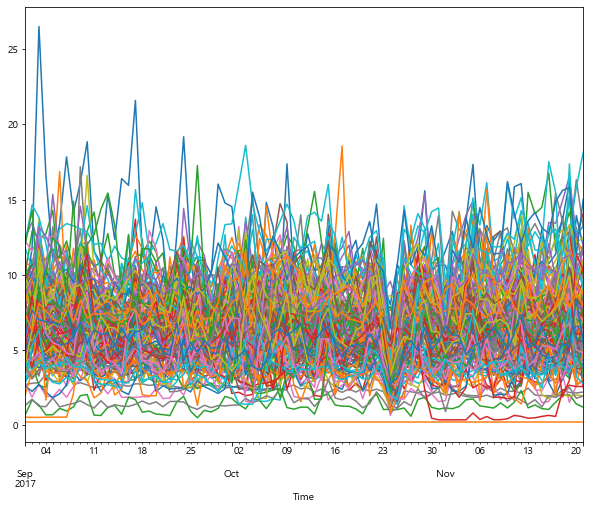

In [56]:
test_sample_nan.resample('D').sum().plot(figsize=(10,8),legend=False)

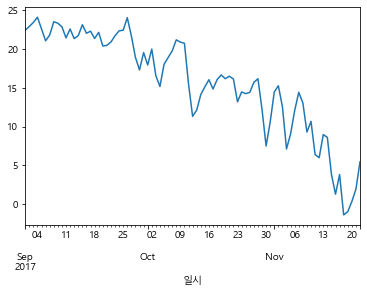

In [57]:
weather['기온(°C)']['2017-09':'2017-11-22'].resample('D').mean().plot()

In [58]:
test_sample_nan.columns

Index(['X303', 'X241', 'X435', 'X402', 'X352', 'X305', 'X350', 'X326', 'X299',
       'X160',
       ...
       'X282', 'X426', 'X192', 'X283', 'X329', 'X223', 'X266', 'X443', 'X347',
       'X230'],
      dtype='object', length=152)

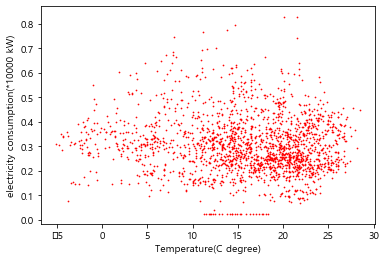

In [59]:
plt.xlabel('Temperature(C degree)')
plt.ylabel('electricity consumption(*10000 kW)')

plt.scatter(weather['기온(°C)']['2017-09':'2017-11-21'], test_sample_nan['X435'],s=0.5,
            color="red", label='electricity consumption(measured)')
plt.show()

In [60]:
# # 학습과 성능의 평가

# from sklearn.model_selection import KFold
# import sklearn.svm

# data_count = len(test_sample_nan['X435'])

# # 교차검정의 준비
# kf = KFold(n_splits=5)

# # 교차검정 실시(모든 패턴을 실시)
# for train, test in kf.split(weather['기온(°C)']['2017-09':'2017-11-21']):
#     x_train = weather['기온(°C)']['2017-09':'2017-11-21'][train]
#     x_test = weather['기온(°C)']['2017-09':'2017-11-21'][test]
#     y_train = test_sample_nan['X435'][train]
#     y_test = test_sample_nan['X435'][test]

#     # -- SVR --
#     model = sklearn.svm.SVR()
#     y_train = y_train.values.flatten()
#     y_test = y_test.values.flatten()
    
#     model.fit(x_train, y_train)
#     print ("SVR: Training Score = %f, Testing(Validate) Score = %f" %
#            (model.score(x_train, y_train), model.score(x_test, y_test)))

In [61]:
# Annual	1
# Quarterly	4
# Monthly	12
# Weekly	52

In [62]:
test_sample.columns

Index(['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107', '기온'],
      dtype='object')

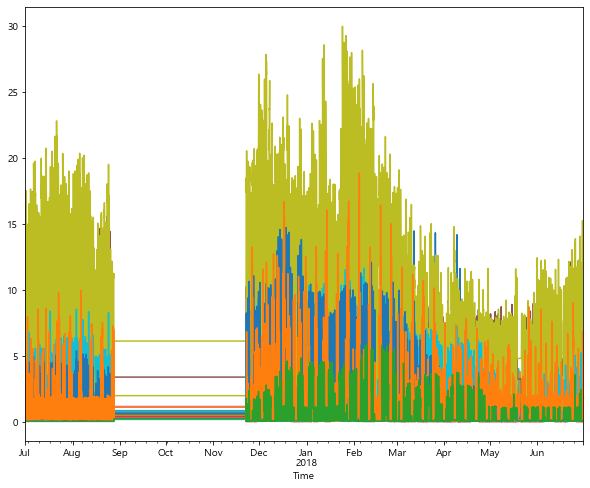

In [63]:
test_sample.loc[:,:'X107'].plot(figsize=(10,8),legend=False)

In [64]:
test_sample.columns

Index(['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107', '기온'],
      dtype='object')

In [65]:
from statsmodels.tsa.api import ExponentialSmoothing

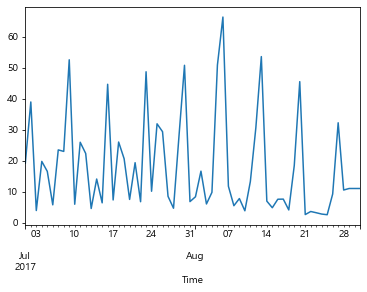

In [66]:
test_sample['X76'][:'2017-08'].resample('D').sum().plot()

In [67]:
winter_model = ExponentialSmoothing(np.asarray(test_sample['X76'][:'2017-08'].resample('D').sum()),
                                   seasonal_periods=12, # 인자로 계절성파악위해 주기 주어야함(12개월 주기)
                                    trend='add', # addtive
                                    seasonal='add' # addtive
                                   ) 

In [68]:
winter_result = winter_model.fit()

C:\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [69]:
y_hat = test_sample['2017-08-20':'2017-08-22'].resample('D').sum().copy() # 원본 test데이터 오염방지위해)

In [70]:
y_hat['WINTER'] = winter_result.forecast(len(test_sample['X125']['2017-08-20':'2017-08-22'].resample('D').sum()))

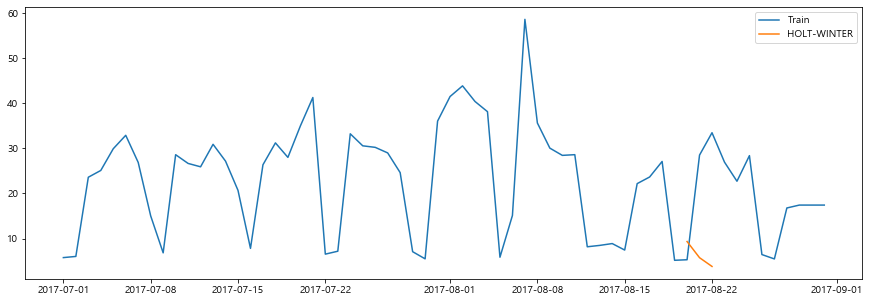

In [71]:
plt.figure(figsize=(15,5))
plt.plot(test_sample['X125'][:'2017-08-31'].resample('D').sum(), label='Train')
plt.plot(y_hat[['WINTER']], label='HOLT-WINTER')
plt.legend()

In [72]:
from statsmodels.tsa.api import Holt

In [73]:
holt_model = Holt(np.asarray(np.asarray(test_sample['X125'][:'2017-08'])))

In [74]:
holt_result = holt_model.fit()

In [75]:
y_hat['HOLT'] = holt_result.forecast(len(test_sample['X125']['2017-08-15':'2017-08']))

ValueError: Length of values does not match length of index

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(test_sample['X125'][:'2017-08-31'], label='Train')
# plt.plot(train['Thousands of Passengers'], label='Test')
plt.plot(y_hat[['HOLT']], label='Holts Exp Smoothing')
plt.legend()

In [ ]:
test_sample['X125'].plot(figsize=(10,10))